# Neural Netwok model with no hidden layers

Author: Tiago Xavier Silva (tiagoxsilva@usp.br)

Based on "*Dive into Deep Learning*", by A. Zhang, Z. C. Lipton, M. Li, A. J. Smola, and "*Neural Networks: Forward and Backpropagation*", from the lecture of N. Sardana.


<center><img src="https://drive.google.com/uc?id=1uZmidhMtvrXMMzDhDMHa0kto1ddfVDlZ" style="height:50px"></center>

The primary goal of this notebook is to model a NN without any hidden layers. Therefore, the system should essentially operate as linear regression:

$$ \hat{y} = Wx + b \rightarrow \hat{y}_{i} = \sum^{n}_{i=1} \left(w_{11} \cdot x_{1}^i + w_{12} \cdot x_{2}^i + b_i\right)$$

where the weight matrix is $$W = \left[w_{11} \,\, w_{12}\right]$$

and the bias matrix $$b = \left[b_{1} \,\, b_{2}\right]$$

The notebook will delve into the fundamental concepts of forward and backpropagation, illustrating the learning process via Mini-Batch Gradient Descent (MBGD)



## Implementation
### Libraries

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

import inspect, collections

### Additional auxiliary classes

In [3]:
class HyperParameters:
  def save_hyperparameters(self, ignore=[]):
    """Saves all arguments in a class’s __init__ method as class attributes"""
    frame = inspect.currentframe().f_back
    local_vars = inspect.getargvalues(frame)[3]

    self.hparams = {k:v for k, v in local_vars.items() if k not in set(ignore+['self']) and not k.startswith('_')}

    for k, v in self.hparams.items():
        setattr(self, k, v)

class ProgressBoard(HyperParameters):
    """Plot experiment progress interactively while it is going on"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):

        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
      Point = collections.namedtuple('Point', ['x', 'y'])

      if not hasattr(self, 'raw_points'):
          self.raw_points = collections.OrderedDict()
          self.data = collections.OrderedDict()

      if label not in self.raw_points:
          self.raw_points[label] = []
          self.data[label] = []

      points = self.raw_points[label]
      line = self.data[label]
      points.append(Point(x, y))

      if len(points) != every_n:
          return

      mean = lambda x: sum(x) / len(x)
      line.append(Point(mean([p.x for p in points]), mean([p.y for p in points])))
      points.clear()

      if not self.display:
          return

      backend_inline.set_matplotlib_formats('svg')

      if self.fig is None:
          self.fig = plt.figure(figsize=self.figsize)
      plt_lines, labels = [], []

      for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
          plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v], linestyle=ls, color=color)[0])
          labels.append(k)

      axes = self.axes if self.axes else plt.gca()

      if self.xlim: axes.set_xlim(self.xlim)
      if self.ylim: axes.set_ylim(self.ylim)
      if not self.xlabel: self.xlabel = self.x

      axes.set_xlabel(self.xlabel)
      axes.set_ylabel(self.ylabel)
      axes.set_xscale(self.xscale)
      axes.set_yscale(self.yscale)
      axes.legend(plt_lines, labels)

      display.display(self.fig)
      display.clear_output(wait=True)

### Class for dataset creation and preparation.

In [4]:
class LinearRegressionData(HyperParameters):
  def __init__(self, w, b, num_train=1000, num_val=1000, batch_size=32):
    super().__init__()
    self.save_hyperparameters()

    n = self.num_train + self.num_val

    # Training and validation dataset
    self.X = torch.randn(n, len(w))
    self.y = torch.matmul(self.X, w.reshape(-1, 1)) + b + torch.randn(n, 1)*0.01

  def get_dataloader(self, train):
    """Prepare train (train=True) and validation (train=False) datasets in batches"""
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    tensors = tuple(a[i] for a in (self.X, self.y))
    dataset = TensorDataset(*tensors)

    return DataLoader(dataset, self.batch_size, shuffle=train)

### Model class

Ignoring biases, which will follow a similar rule, it's know from the forward propagation that:

$$ \hat{y} = Wx $$

and the error is

$$ E = \frac{1}{2} ||\hat{y} - y||^2$$

According to the mini-batch gradient descent, in order to minimize the error $E$, we should update the parameters as follows:

$$ W \leftarrow W - \frac{\eta}{|\mathcal{B}|} \sum_{i \,\in\, \mathcal{B}} \frac{\partial E \left(x^{(i)}, y^{(i)}, W\right)}{\partial W}$$  <br>


> (i) Compute the gradient against a batch $\mathcal{B}$ of training examples; <br>

> (ii) Update parameters according to a learning rate $\eta$




In [5]:
class MBGD(HyperParameters):
    """Mini-batch gradient descent"""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
class LinearRegression(HyperParameters):
  def __init__(self, lr, num_features=2):
    super().__init__()
    self.save_hyperparameters()

    self.board = ProgressBoard()
    self.plot_train_per_epoch = 2
    self.plot_valid_per_epoch = 1

    # Weight and bias initialization
    # The torch.tensor.requires_grad attribute is set to True when gradients need to be computed for the tensor.
    self.W = torch.normal(0, 0.01, (num_features, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)

  def plot(self, key, value, train):
    """Plot a point in animation."""
    self.board.xlabel = 'epoch'
    if train:
        x = self.trainer.train_batch_idx / \
            self.trainer.num_train_batches
        n = self.trainer.num_train_batches / \
            self.plot_train_per_epoch
    else:
        x = self.trainer.epoch + 1
        n = self.trainer.num_val_batches / \
            self.plot_valid_per_epoch
    self.board.draw(x, value.detach().numpy(), ('train_' if train else 'val_') + key, every_n=int(n))

  def forward(self, X):
    """Forward propagation method"""
    return torch.matmul(X, self.W) + self.b

  def loss(self, y_hat, y):
    """Loss function (MSE)"""
    l = ((y_hat - y)**2)/ 2
    return l.mean()

  def configure_optimizers(self):
    return MBGD([self.W, self.b], self.lr)

  def training_step(self, batch):
    l = self.loss(self.forward(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=True)
    return l

  def validation_step(self, batch):
    l = self.loss(self.forward(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=False)

### Training class

In [7]:
class Trainer(HyperParameters):
  def __init__(self, num_epochs):
    super().__init__()
    self.save_hyperparameters()

  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()

    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0

    for self.epoch in range(self.num_epochs):
        self.fit_epoch()

  def fit_epoch(self):
    for batch in self.train_dataloader:
      loss = self.model.training_step(batch)

      #Backpropagation
      self.optim.zero_grad()

      with torch.no_grad():
        loss.backward()
        self.optim.step()

      self.train_batch_idx += 1

    for batch in self.val_dataloader:
      with torch.no_grad():
        self.model.validation_step(batch)
      self.val_batch_idx += 1

  def prepare_data(self, data):
    """Get train and validation dataset batches"""
    self.train_dataloader = data.get_dataloader(train=True)
    self.val_dataloader = data.get_dataloader(train=False)
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = len(self.val_dataloader)

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.num_epochs]
    self.model = model

## Practical example of the project above

In [15]:
# Dataset and linear regression model
data = LinearRegressionData(w=torch.tensor([2, -3.4]), b=4.2, num_train=1000, num_val=1000, batch_size=20)
model = LinearRegression(lr=0.01)

print("Initial weight tensor:\n", model.W.data, "\n\nInitial bias tensor:\n", model.b.data)

Initial weight tensor:
 tensor([[0.0031],
        [0.0028]]) 

Initial bias tensor:
 tensor([0.])


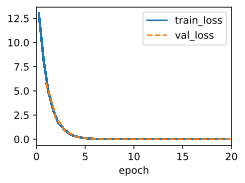

In [16]:
# Training loops
trainer = Trainer(num_epochs=20)
trainer.fit(model, data)

In [17]:
# Results
print("Estimated weight tensor:\n", model.W.data, "\n\nEstimated bias tensor:\n", model.b.data)

Estimated weight tensor:
 tensor([[ 2.0002],
        [-3.4004]]) 

Estimated bias tensor:
 tensor([4.1994])
